---
# Surface Solar Radiation (SSR) - Overview
---
This notebook provides an overview of daily mean SSR distribution statistics (spread, median, skewness, kurtosis). 

The data used in this notebook are from:
- CMIP6 Climate models 
- WRDC Observations (Station of Kloten in the Canton of Zürich, Switzerland)

Copyright (c) 2023, ETH Zurich, Guillaume Senger

In [1]:
import my_functions
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec
from scipy.stats import skew, kurtosis
import warnings
import pandas as pd
from collections import Counter


warnings.filterwarnings("ignore", message="Warning: 'partition' will ignore the 'mask' of the MaskedArray.")
matplotlib.rcParams.update({'font.size': 24})

---
## Loading Data

We are loading the data from the models for a specific location.

In [2]:
location      = 'Berlin'
# location      = 'Edmonton'
# location      = 'Honolulu'
# location      = 'London'
# location      = 'Madrid'
# location      = 'Manaus'
# location      = 'New Dehli'
# location      = 'Paris'
# location      = 'Zurich'
# location = 'South Pole'
# location = 'North Pole'

rsds_models   = pickle.load(open(f'Data/rsds/{location}.pickle', 'rb')) # Load data created using the script Get_Data_Local.py

print(f'CMIP6 rsds data for the grid box containing {location}:\n')
for model_name in rsds_models:
    print(f'    {model_name}: {len(rsds_models[model_name])//365} years')

CMIP6 rsds data for the grid box containing Berlin:

    CanESM5: 1000 years
    CESM2: 1190 years
    CMCC-CM2-SR5: 500 years
    CMCC-ESM2: 500 years
    GFDL-CM4: 140 years
    GFDL-ESM4: 500 years
    NorESM2-LM: 501 years
    NorESM2-MM: 500 years
    TaiESM1: 500 years


We are loading the data from the WRDC Observations

In [3]:
def get_SSR_obs(file_path):
    SSR_values = []
    flag_values = []
    
    with open(file_path, 'r') as file:
        lines = file.readlines()
        start_reading = False
        for line in lines:
            if line.startswith("---"):
                start_reading = True
                continue
            if start_reading:
                if line.startswith("SUM") or line.startswith("MEAN"):
                    break

                line_values = line.split("|")[0:]

                flag_values.extend([val.strip() for val in line_values[2::2]])
                SSR_values.extend([val.strip() for val in line_values[1::2]])

    # Merge true_values and false_values into one array
    merged_values = [(SSR_val, flag_val) for SSR_val, flag_val in zip(SSR_values, flag_values)]

    # Organize values into columns
    num_days = 31
    num_months = 12
    column_values = []
    for j in range(num_months):
        for i in range(num_days):
            column_values.append(merged_values[j + i * num_months])
            

    del column_values[340] 
    del column_values[278]
    del column_values[185]
    del column_values[123]
    del column_values[61]
    del column_values[60]
    del column_values[59]
    
    filtered_data = [(x, y) for x, y in column_values]
    filtered_data = [(np.nan if x == '-' and y == '-' else x, np.nan if x == '-' and y == '-' else y) for x, y in column_values]


    quality_flag = [y for _ , y in filtered_data]
    flag_counts = Counter(quality_flag)

    # Get rid of bad quality data and change units to W/m2
    filtered_data = [(np.nan if y not in ('0', '3') else x, y) for x, y in filtered_data if y != '-']
    filtered_data = [(int(float(x))*100/864, int(float(y))*100/864) if isinstance(x, str) and x != 'nan' else (np.nan, np.nan) for x, y in filtered_data]

    return filtered_data, flag_counts

In [4]:
if location == 'Zurich':

    year_init  = 1981
    year_final = 2022

    file_paths = ['/net/o3/hymet/smithpa/WRDC_DL20240111-17/glbrad6/daily/switzerland_zuerich_kloten__zuerich_kloten__{}_t6.txt'.format(year) for year in range(year_init, year_final + 1)]

if location == 'Berlin':

    year_init  = 1964
    year_final = 1998

    problematic_years = [1966]

    file_paths = [
        '/net/o3/hymet/smithpa/WRDC_DL20240111-17/glbrad6/daily/germany_potsdam__potsdam__{}_t6.txt'.format(year)
        for year in range(year_init, year_final + 1)
        if year not in problematic_years
    ]

    file_paths.append('/home/gsenger/master_thesis_PAPER/germany_potsdam__potsdam__1966_t6.txt')

if location == 'Paris':

    year_init  = 1978
    year_final = 2022

    problematic_years = list(range(1996, 2009))

    file_paths = [
        '/net/o3/hymet/smithpa/WRDC_DL20240111-17/glbrad6/daily/france_paris-montsouris__paris-montsouris__{}_t6.txt'.format(year)
        for year in range(year_init, year_final + 1)
        if year not in problematic_years
    ]


# Initialize an empty list to store all values
rsds_obs_data = []
overall_flag_counts = Counter()

# Iterate over each file path
for file_path in file_paths:

    rsds_obs_one_year, flag_counts = get_SSR_obs(file_path)
    rsds_obs_data.extend(rsds_obs_one_year)
    overall_flag_counts.update(flag_counts)


rsds_obs = [x for x, _ in rsds_obs_data]
quality_flag = [y for _ ,y in rsds_obs_data]


n_years_obs = len(rsds_obs)//365

reshaped_rsds_obs = my_functions.reshape(rsds_obs)

print(f'WRDC Observations ({year_init}-{year_final}) for the station close to {location}: {len(rsds_obs)/365:.0f} years\n')

print(f'Observations quality:')

print(f"Flag 0: {overall_flag_counts['0']}/{len(rsds_obs)} ({np.round(overall_flag_counts['0']/len(rsds_obs)*100,2)}%) -> Good value")
print(f"Flag 1: {overall_flag_counts['1']}/{len(rsds_obs)} ({np.round(overall_flag_counts['1']/len(rsds_obs)*100,2)}%) -> Questionable value as estimated at National Meteorological Service")
print(f"Flag 2: {overall_flag_counts['2']}/{len(rsds_obs)} ({np.round(overall_flag_counts['2']/len(rsds_obs)*100,2)}%) -> Value is not available or is rejected at National Meteorological Service")
print(f"Flag 3: {overall_flag_counts['3']}/{len(rsds_obs)} ({np.round(overall_flag_counts['3']/len(rsds_obs)*100,2)}%) -> Value calculated or interpolated at National Meteorological Service")
print(f"Flag 4: {overall_flag_counts['4']}/{len(rsds_obs)} ({np.round(overall_flag_counts['4']/len(rsds_obs)*100,2)}%) -> Polar night")
print(f"Flag 5: {overall_flag_counts['5']}/{len(rsds_obs)} ({np.round(overall_flag_counts['5']/len(rsds_obs)*100,2)}%) -> Questionable value as estimated at WRDC")
print(f"Flag 6: {overall_flag_counts['6']}/{len(rsds_obs)} ({np.round(overall_flag_counts['6']/len(rsds_obs)*100,2)}%) -> Value considered outlier to own climate-defined upper limit as estimated at WRDC")
print(f"Flag 7: {overall_flag_counts['7']}/{len(rsds_obs)} ({np.round(overall_flag_counts['7']/len(rsds_obs)*100,2)}%) -> Questionable value as estimated at WRDC")
print(f"Flag 8: {overall_flag_counts['8']}/{len(rsds_obs)} ({np.round(overall_flag_counts['8']/len(rsds_obs)*100,2)}%) -> Diffuse radiation value exceeds associated global radiation value")
print(f"Flag 9: {overall_flag_counts['9']}/{len(rsds_obs)} ({np.round(overall_flag_counts['9']/len(rsds_obs)*100,2)}%) -> Value is rejected at WRDC")

WRDC Observations (1964-1998) for the station close to Berlin: 35 years

Observations quality:
Flag 0: 12678/12775 (99.24%) -> Good value
Flag 1: 14/12775 (0.11%) -> Questionable value as estimated at National Meteorological Service
Flag 2: 21/12775 (0.16%) -> Value is not available or is rejected at National Meteorological Service
Flag 3: 0/12775 (0.0%) -> Value calculated or interpolated at National Meteorological Service
Flag 4: 0/12775 (0.0%) -> Polar night
Flag 5: 0/12775 (0.0%) -> Questionable value as estimated at WRDC
Flag 6: 0/12775 (0.0%) -> Value considered outlier to own climate-defined upper limit as estimated at WRDC
Flag 7: 0/12775 (0.0%) -> Questionable value as estimated at WRDC
Flag 8: 0/12775 (0.0%) -> Diffuse radiation value exceeds associated global radiation value
Flag 9: 0/12775 (0.0%) -> Value is rejected at WRDC


---
## Statistics Computation and Visualisation


For each calendar day, we compute the statistics (minimum, maximum, median, skewness, kurtosis) on all daily mean SSR value for that specific calendar day

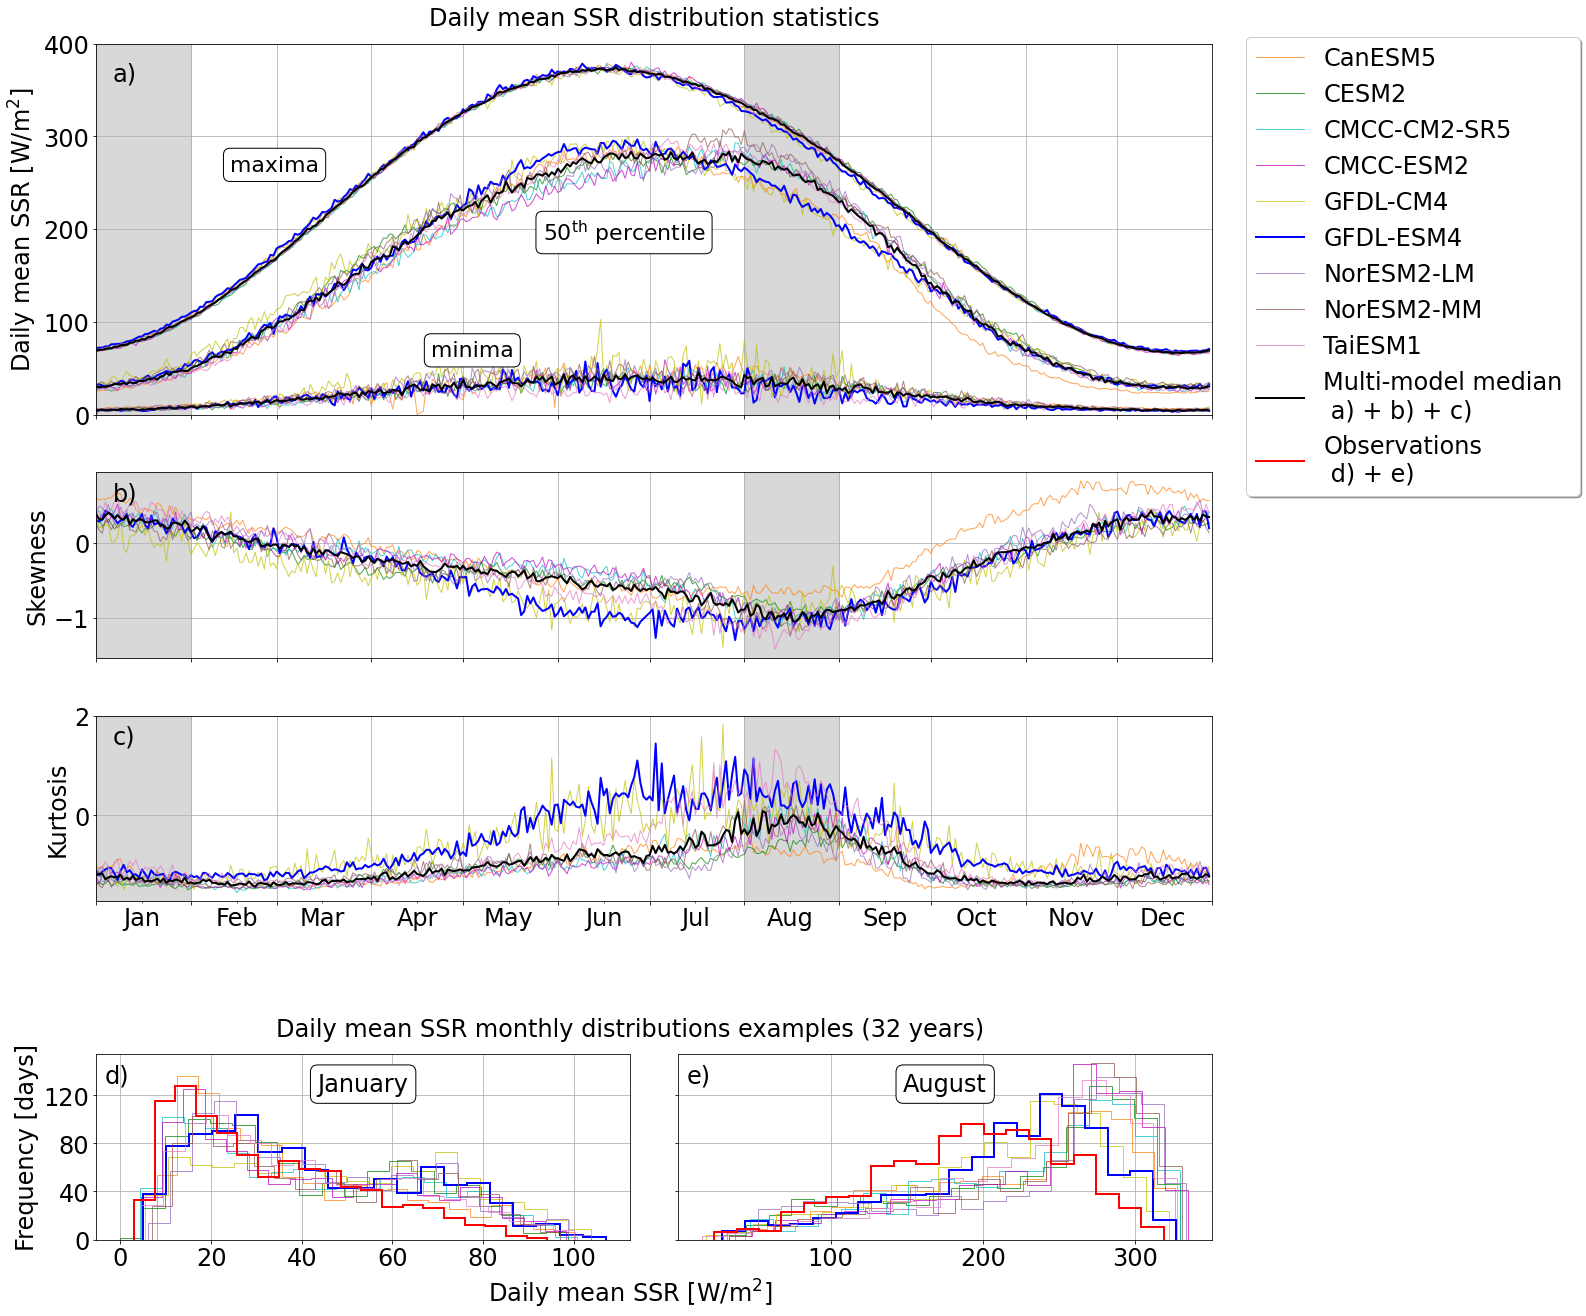

In [50]:
# Style dictionnary for the Figure and choice of models
style_dict = {
    'CanESM5':         {'color': 'tab:orange', 'linewidth': 1  , 'linestyle': '-'     , 'alpha': 0.7},
    'CESM2':           {'color': 'g'         , 'linewidth': 1  , 'linestyle': '-'     , 'alpha': 0.7},
    'CMCC-CM2-SR5':    {'color': 'c'         , 'linewidth': 1  , 'linestyle': '-'     , 'alpha': 0.7},
    'CMCC-ESM2':       {'color': 'm'         , 'linewidth': 1  , 'linestyle': '-'     , 'alpha': 0.7},
    'GFDL-CM4':        {'color': 'y'         , 'linewidth': 1  , 'linestyle': '-'     , 'alpha': 0.7},
    'GFDL-ESM4':       {'color': 'b'         , 'linewidth': 2  , 'linestyle': '-'     , 'alpha': 1  }, # Main model
    'NorESM2-LM':      {'color': 'tab:purple', 'linewidth': 1  , 'linestyle': '-'     , 'alpha': 0.7},
    'NorESM2-MM':      {'color': 'tab:brown' , 'linewidth': 1  , 'linestyle': '-'     , 'alpha': 0.7},
    'TaiESM1':         {'color': 'tab:pink'  , 'linewidth': 1  , 'linestyle': '-'     , 'alpha': 0.7},
    # 'INM-CM4-8':       {'color': 'tab:gray'  , 'linewidth': 1.5, 'linestyle': 'dotted', 'alpha': 1  }, # Left out for the analysis
    # 'INM-CM5-0':       {'color': 'tab:olive' , 'linewidth': 1.5, 'linestyle': 'dotted', 'alpha': 1  }, # Left out for the analysis
    # 'IPSL-CM5A2-INCA': {'color': 'tab:cyan'  , 'linewidth': 1.5, 'linestyle': 'dotted', 'alpha': 1  }, # Left out for the analysis
    # 'KIOST-ESM':       {'color': 'tab:olive' , 'linewidth': 1.5, 'linestyle': 'dotted', 'alpha': 1  }  # Left out for the analysis
}

fig = plt.figure(figsize = (20,22))
gs  = fig.add_gridspec(nrows=5, ncols=2, height_ratios=[2, 1, 1, 0.2, 1], wspace=0.09, hspace=0.3) 

ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, :])
ax3 = fig.add_subplot(gs[2, :])
ax4 = fig.add_subplot(gs[-1, :-1])
ax5 = fig.add_subplot(gs[-1, -1])

all_mins, all_medians, all_maxs, all_skewness, all_kurtosis = {}, {}, {}, {}, {} # To compute the multi-model median afterwards

for model_name, rsds in rsds_models.items():

    if model_name in style_dict: # To ignore the commented models in style_dict

        reshaped_rsds = my_functions.reshape(rsds)

        mins          = np.nanmin(reshaped_rsds, axis = 0)
        medians       = np.nanpercentile(reshaped_rsds, 50, axis = 0)
        maxs          = np.nanmax(reshaped_rsds, axis = 0)
        skewness      = skew(reshaped_rsds    , axis = 0)
        kurt          = kurtosis(reshaped_rsds, axis = 0)

        color, linewidth, linestyle, alpha = style_dict[model_name].values()

        ax1.plot(mins    , color = color, linestyle = linestyle, alpha = alpha, linewidth = linewidth)
        ax1.plot(medians , color = color, linestyle = linestyle, alpha = alpha, linewidth = linewidth)
        ax1.plot(maxs    , color = color, linestyle = linestyle, alpha = alpha, linewidth = linewidth, label = model_name)
        ax2.plot(skewness, color = color, linestyle = linestyle, alpha = alpha, linewidth = linewidth)
        ax3.plot(kurt    , color = color, linestyle = linestyle, alpha = alpha, linewidth = linewidth)

        # Histogram for January (Only 38 years to compare with Observations)
        ax4.hist(reshaped_rsds[0:n_years_obs, 0:31].flatten()   , bins=20, density=False, histtype='step', color = color, linestyle = linestyle, alpha = alpha, linewidth = linewidth) 

        # Histogram for August (Only 38 years to compare with Observations)
        ax5.hist(reshaped_rsds[0:n_years_obs, 212:243].flatten(), bins=20, density=False, histtype='step', color = color, linestyle = linestyle, alpha = alpha, linewidth = linewidth) 

        # To compute the multi-model median afterwards
        all_mins[model_name]     = mins
        all_medians[model_name]  = medians
        all_maxs[model_name]     = maxs
        all_skewness[model_name] = skewness
        all_kurtosis[model_name] = kurt

# Plot the multi-model medians 
ax1.plot(np.median(list(all_mins.values())    , axis = 0), color = 'black', linewidth = 2)
ax1.plot(np.median(list(all_medians.values()) , axis = 0), color = 'black', linewidth = 2, label = 'Multi-model median \n a) + b) + c)')
ax1.plot(np.median(list(all_maxs.values())    , axis = 0), color = 'black', linewidth = 2)
ax2.plot(np.median(list(all_skewness.values()), axis = 0), color = 'black', linewidth = 2)
ax3.plot(np.median(list(all_kurtosis.values()), axis = 0), color = 'black', linewidth = 2)

# plot the histogram for Observations if the location is Zürich
if location in ['Zurich', 'Paris', 'Berlin']:

    ax4.hist(reshaped_rsds_obs[:, 0:31].flatten()   , bins=20, linewidth=2, density=False, histtype='step', color = 'red') # Histogram of January
    ax5.hist(reshaped_rsds_obs[:, 212:243].flatten(), bins=20, linewidth=2, density=False, histtype='step', color = 'red') # Histogram of August

    ax1.plot([-10,0], [0, 0], linewidth=2, color = 'red', label = 'Observations\n d) + e)') # Useless plot to add the label to the legend of ax1


# plot technical parameters

ax1.legend(bbox_to_anchor=(1.02, 1.05), ncol=1, fancybox=True, shadow=True) 

ax1.set_ylim(0,400) 


for ax in [ax2, ax3]:
    y_min, y_max = ax.get_ylim()
    ax.set_ylim(y_min, y_max)
   

for ax in [ax1, ax2, ax3]:

    # Add grey shading to show the months considered for the histograms
    y_min, y_max = ax.get_ylim()
    ax.fill_betweenx([y_min, y_max], 0, 31, color='gray', alpha=0.3) 
    ax.fill_betweenx([y_min, y_max], 212, 243, color='gray', alpha=0.3)

    
    ax.set_xlim(0,364)
    ax.set_xticks([0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334, 365]) 
    ax.set_xticklabels([], rotation=45)
    ax.set_xticklabels('')
    ax.grid()
     




y_min_4, y_max_4 = ax4.get_ylim()
y_min_5, y_max_5 = ax5.get_ylim()

ax4.grid()   
ax5.grid()   
ax5.set_yticklabels('')
ax4.set_yticks([0, 40,80,120, 160, 200, 240, 280, 320])
ax5.set_yticks([0, 40,80,120, 160, 200, 240, 280, 320])
# ax4.set_ylim(0,180)
# ax5.set_ylim(0,180)



ax4.set_ylim(0,max(y_max_4,y_max_5))
ax5.set_ylim(0,max(y_max_4,y_max_5))




ax3.set_xticks([15, 46, 74, 105, 135, 166, 196, 227, 258, 288, 319, 349], minor=True)
ax3.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], minor=True)
    
ax1.set_ylabel('Daily mean SSR [W/m$^2$]')
ax2.set_ylabel('Skewness')
ax3.set_ylabel('Kurtosis')
ax4.set_ylabel('Frequency [days]')

ax1.text(0.5 ,  1.1 , 'Daily mean SSR distribution statistics', transform=ax1.transAxes, va='top', ha = 'center')
ax4.text(1.0 ,  1.2 , f'Daily mean SSR monthly distributions examples ({n_years_obs} years)', transform=ax4.transAxes, va='top', ha = 'center')
ax4.text(1.0 , -0.2 , 'Daily mean SSR [W/m$^2$]', ha = 'center', transform=ax4.transAxes, va='top')
ax4.text(0.5 ,  0.8 , 'January', ha = 'center', transform=ax4.transAxes, color='black', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))
ax5.text(0.5 ,  0.8 , 'August' , ha = 'center', transform=ax5.transAxes, color='black', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))
ax1.text(0.12,  0.7 , 'maxima', transform=ax1.transAxes, va='top', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'), fontsize = 22)
ax1.text(0.4 ,  0.53, '$50^{\mathrm{th}}$ percentile', transform=ax1.transAxes, va='top', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'), fontsize = 22)
ax1.text(0.3 ,  0.2 , 'minima', transform=ax1.transAxes, va='top', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'), fontsize = 22)
ax1.text(0.015, 0.95, 'a)', transform=ax1.transAxes, va='top')
ax2.text(0.015, 0.95, 'b)', transform=ax2.transAxes, va='top')
ax3.text(0.015, 0.95, 'c)', transform=ax3.transAxes, va='top')
ax4.text(0.015, 0.95, 'd)', transform=ax4.transAxes, va='top')
ax5.text(0.015, 0.95, 'e)', transform=ax5.transAxes, va='top')

plt.savefig(f'Figures/SSR_Overview/Overview_{len(style_dict)}_models_{location}.png', bbox_inches='tight')

plt.show()

---
## Density Plots

We compare density plots (number of day falling within a $1$ day $\times$ $1$ $W/m^2$ window) of Observations and one climate model for the grid box containing Zürich.

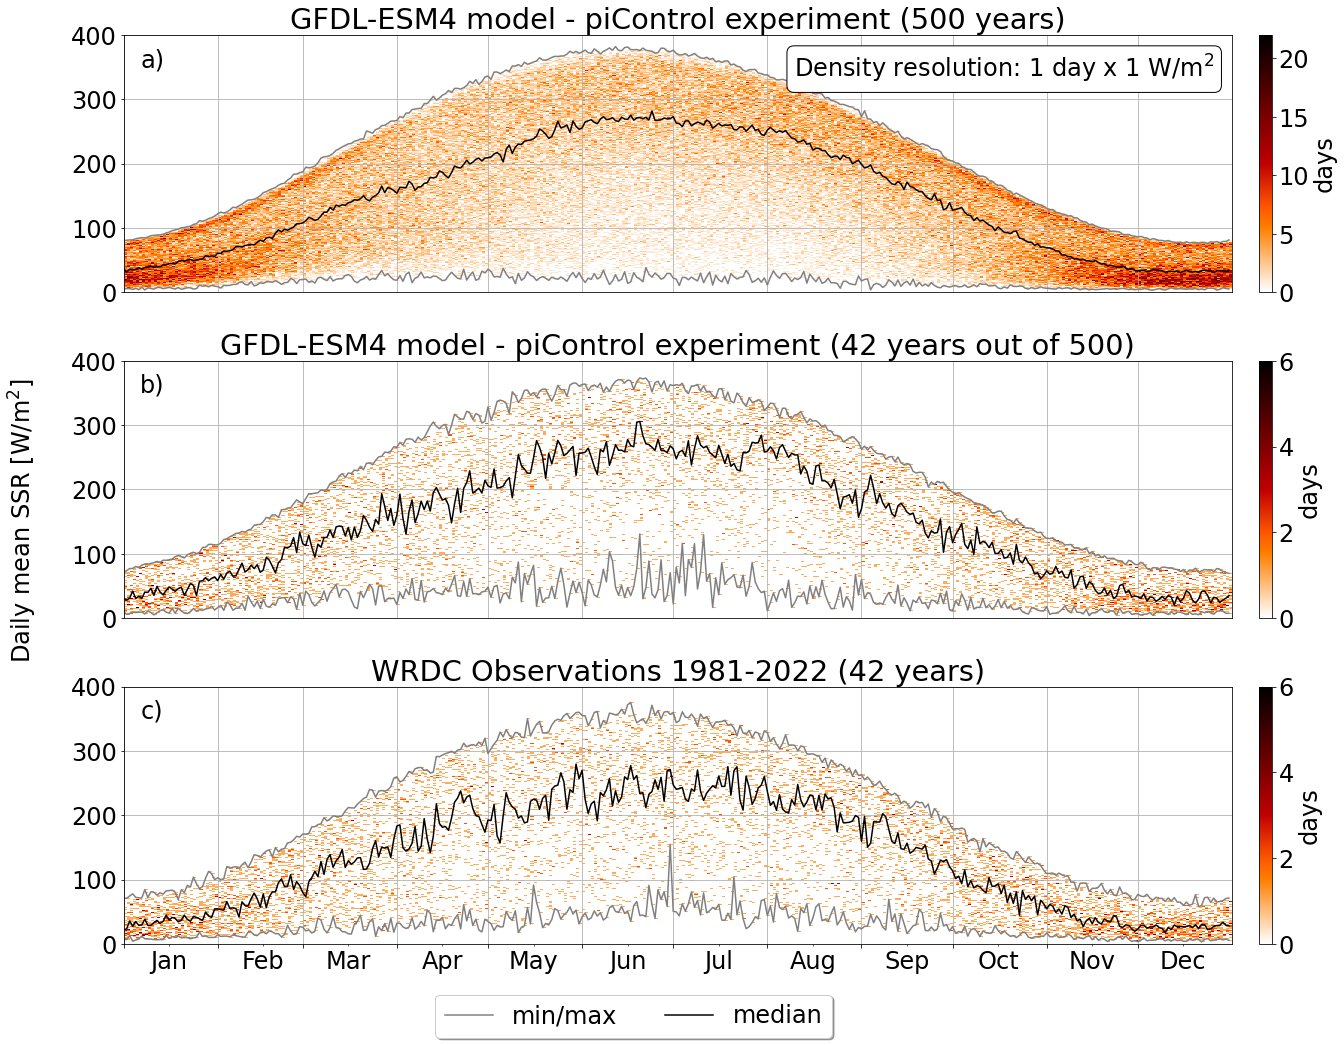

In [13]:
model_name = 'GFDL-ESM4'

rsds_models_Zurich   = pickle.load(open(f'Data/rsds/Zurich.pickle', 'rb'))
rsds_model           = rsds_models_Zurich[model_name]
n_years_model        = len(rsds_model)//365

vmaxs = [22, 6, 6]

fig = plt.figure(figsize = (20,15))
gs  = fig.add_gridspec(3,1)


for i, rsds_to_plot in enumerate([rsds_model,                   # Model Data - Full length
                                  rsds_model[0:len(rsds_obs)],  # Model Data - Same length as the Observations
                                  rsds_obs]):                   # Observations

    ax = fig.add_subplot(gs[i,0])

    reshaped_rsds = my_functions.reshape(rsds_to_plot)
    
    # Compute and plot minimum, maximum and median daily values
    medians       = np.nanpercentile(reshaped_rsds, 50, axis = 0)
    mins          = np.nanmin(reshaped_rsds, axis = 0)
    maxs          = np.nanmax(reshaped_rsds, axis = 0)

    ax.plot(maxs,    color = 'gray',  label = 'min/max')
    ax.plot(medians, color = 'black', label = 'median' )
    ax.plot(mins,    color = 'gray')


    # Compute and plot density (only daily values smaller than 400 W/m^2 considered)
    density        = np.zeros((400, 365))

    for day in range(365):
        
        for val in reshaped_rsds[:,day]:  
            if val < 400:
                density[int(val), day] += 1


    pcolormesh = ax.pcolormesh(density, cmap = 'gist_heat_r', vmax = vmaxs[i])
    colorbar = fig.colorbar(pcolormesh, ax=ax, pad=0.02, label = 'days')

    # Set plot parameters
    if i == 0:
        ax.set_title(f'{model_name} model - piControl experiment ({n_years_model} years)')
        ax.text(0.015, 0.95, 'a)', transform=ax.transAxes, va='top')

    if i == 1:
        ax.set_title(f'{model_name} model - piControl experiment ({n_years_obs} years out of {n_years_model})')
        ax.text(0.015, 0.95, 'b)', transform=ax.transAxes, va='top')

    if i == 2:
        ax.set_title(f'WRDC Observations {year_init}-{year_final} ({n_years_obs} years)')
        ax.text(0.015, 0.95, 'c)', transform=ax.transAxes, va='top')

    ax.set_xticks([0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334]) 

    if i != 2:
        ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    else:
        ax.legend(bbox_to_anchor=(0.65, -0.15), ncol=2, fancybox=True, shadow=True)
        ax.set_xticklabels('')
        ax.set_xticks([15, 46, 74, 105, 135, 166, 196, 227, 258, 288, 319, 349], minor=True)
        ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], minor=True)


    if i == 0:
        ax.text(0.605, 0.93, 'Density resolution: 1 day x 1 W/m$^2$', transform=ax.transAxes, verticalalignment='top', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))

    ax.grid()


fig.text(-0.015, 0.5, 'Daily mean SSR [W/m$^2$]', ha='center', va='center',fontsize = 24, rotation = 'vertical')

plt.tight_layout()

plt.savefig(f'Figures/SSR_Overview/SSR_Range_{model_name}.png', bbox_inches='tight')
plt.show()

---
## WRDC Observations SREs visualisation

We plot the decadal occurrence of the WRDC observation 38-year time series to compare our results with real life measurements.

See the SSR_Overview notebook for more details about the observations.

SUSTAINED RADIATION EVENTS
--------------------------
Time series duration: 42 years (15330 days)

Percentiles considered: 1th to 99th

SREs lengths considered:
      mininum  3 consecutive days
      maxinum 16 consecutive days

For each percentile, available outputs are:
          - thresholds_all_years (15330,): give the daily thresholds for all simulation days
          - rsds_all_years_above (15330,): binary array with 1: exceed daily threshold, 0: do not exceed daily threshold
          - SREs_all_years (15330,): give the SRE length at the first day of all SREs, 0 otherwise
          - extreme_events_per_day (365, 17): give how many events of length L are observed for each calendar day

SREs computed successfully.


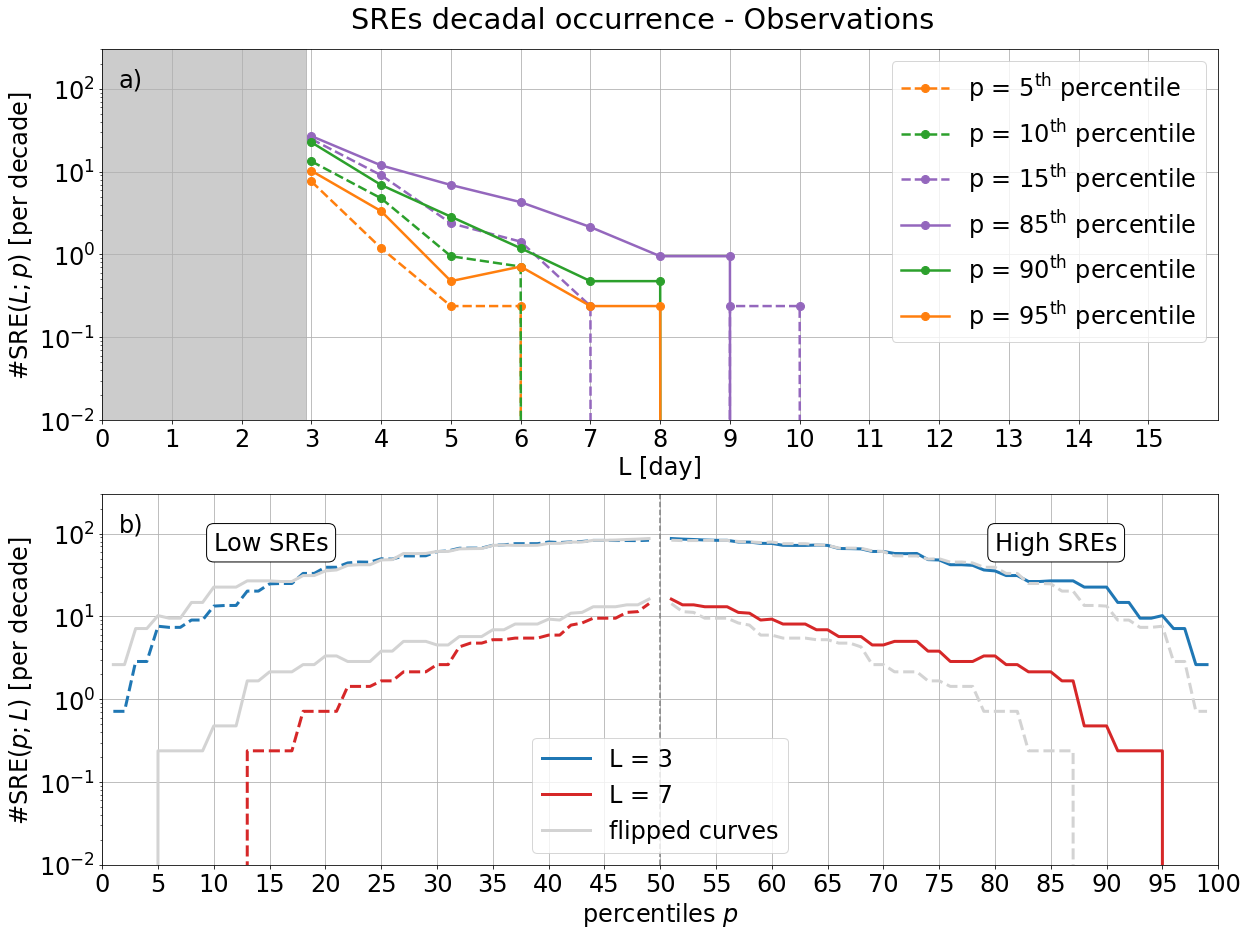

In [14]:
percentiles = np.arange(1, 100, 1) # Choose the percentiles of interest for the maps

min_length  = 3                    # Choose the min SREs length we want to consider
max_length  = 16   
# Set plot parameters
percentiles_to_plot = [5, 10, 15, 85, 90, 95] # Choose the percentiles we want to show (6 complementary percentiles only)
colors_percentiles  = ["tab:orange", "tab:green", "tab:purple"] # Colors for the top plot

L_to_plot           = [3, 7] # Choose the lengths we want to show (2 lengths only)
colors_L            = ['tab:blue', 'tab:red'] # Colors for the bottom plot

# Compute SREs on the observations
output_SREs_Obs = my_functions.compute_SREs(rsds_obs, percentiles='all')


# Built of shape n_percentiles x (max_length+1) to have the SREs occurence of all percentiles and length considered
SREs_extreme_events_per_day_array = np.zeros((len(percentiles), max_length+1))

for p, percentile in enumerate(percentiles):

    SREs_extreme_events_per_day_array[p,:] = np.sum(output_SREs_Obs[percentile]['extreme_events_per_day'], axis = 0)


fig = plt.figure(figsize = (20,15))
gs  = fig.add_gridspec(nrows=2, ncols=1)

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

plt.suptitle('SREs decadal occurrence - Observations').set_y(0.92)


ax = ax1 # Plot decadal occurrence as function of L for model_name

for p, percentile in enumerate(percentiles_to_plot):
    
    i = percentiles.tolist().index(percentile) # get index corresponding to percentile

    # Set linestyle and color based on the percentile value
    if percentile <= 50:
        linestyle = '--'
        cmap_plot = colors_percentiles[p]
    else:
        linestyle = '-'
        cmap_plot = colors_percentiles[len(percentiles_to_plot)-p-1] # To have the same color for p (p>50) and 100-p

    to_plot = SREs_extreme_events_per_day_array[i,:]/n_years_obs*10 # Decadal occurrence as a function of L
            
    x = np.arange(3,max_length+1)
    y = to_plot[3:] # We are only interested in L > 2 SREs

    ax.plot(x, y, label=f'p = {percentile}$^{{\mathrm{{th}}}}$ percentile', linestyle=linestyle, marker='o', color=cmap_plot, linewidth=2.5, markersize=8) # Show the decadal occurrence

# Set plot aesthetics and labels
ax.set_xlim(0, x[-1])
ax.fill_betweenx(np.linspace(0,1000), 0, 2.92, color='gray', alpha=0.4)
ax.set_ylim(0.01,300)
ax.set_xticks(np.arange(max_length))
ax.set(xlabel='L [day]', ylabel='$\#\mathrm{SRE}(L;p)$ [per decade]')


ax = ax2 # Plot decadal occurrence as function of p for model_name

for L_index, L in enumerate(L_to_plot):
    
    to_plot = SREs_extreme_events_per_day_array[:,L]/n_years_obs*10 # Decadal occurrence as a function of L

    ax.plot(percentiles[0:49], to_plot[0:49]      , linestyle = '--', linewidth = 3, color = colors_L[L_index])                         # Show low SREs
    ax.plot(percentiles[50:] , to_plot[50:]       , linestyle = '-' , linewidth = 3, color = colors_L[L_index], label=f'L = {L}')       # Show high SREs
    
    # Show flipped curves 
    ax.plot(percentiles[50:] , to_plot[0:49][::-1], linestyle = '--', linewidth = 3, color = 'lightgray')                              
    if L_index == 1:
        ax.plot(percentiles[0:49], to_plot[50:][::-1] , linestyle = '-' , linewidth = 3, color = 'lightgray', label='flipped curves')  
    else:
        ax.plot(percentiles[0:49], to_plot[50:][::-1] , linestyle = '-' , linewidth = 3, color = 'lightgray')                          
    
# Set plot aesthetics and labels
ax.axvline(x=50, color='gray', linestyle='--')

ax.text(.1, .85, f'Low SREs', horizontalalignment='left', transform=ax.transAxes, color='black', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))
ax.text(.8, .85, f'High SREs', horizontalalignment='left', transform=ax.transAxes, color='black', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))

ax.set(xlabel='', ylabel='$\#\mathrm{SRE}(p;L)$ [per decade]')
ax.set_xticks(np.arange(0,101, 5))
ax.set_xlim(0, 100)
ax.set_ylim(0.01,300)
ax.set_xlabel('percentiles $p$')


for ax in [ax1, ax2]:

    ax.set_yscale('log') # Set logarithmic y-scale
    ax.legend()
    ax.grid()

ax1.text(0.015, 0.95, 'a)', transform=ax1.transAxes, va='top')
ax2.text(0.015, 0.95, 'b)', transform=ax2.transAxes, va='top')

plt.savefig(f'Figures/SREs_Analysis/Fig_Observations.png', bbox_inches='tight')
plt.show()